In [33]:
import numpy as np
import ot
import os
import matplotlib.pyplot as plt
from einops import rearrange
from MNISTDigitDataset import MNISTDigitDataset
from torchvision import transforms
from utils import plot_pca_for_arrays, plot_images_from_datasets, visualize_barycenter_diracs

In [2]:
target_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        ])
target_transform_jitter=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.ColorJitter(brightness=0.3, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomRotation(degrees=(45, 135))
        ])


ds_4 = MNISTDigitDataset(root='/Users/balazsmorvay/PycharmProjects/fmri_classifier/Data/MNIST/raw',
                         train=True,
                         download=True,
                         transform=target_transform,
                         digit=6)
ds_2 = MNISTDigitDataset(root='/Users/balazsmorvay/PycharmProjects/fmri_classifier/Data/MNIST/raw',
                         train=True,
                         download=True,
                         transform=target_transform,
                         digit=2)
ds_4jr = MNISTDigitDataset(root='/Users/balazsmorvay/PycharmProjects/fmri_classifier/Data/MNIST/raw',
                         train=True,
                         download=True,
                         transform=target_transform_jitter,
                         digit=6)
ds_2jr = MNISTDigitDataset(root='/Users/balazsmorvay/PycharmProjects/fmri_classifier/Data/MNIST/raw',
                         train=True,
                         download=True,
                         transform=target_transform_jitter,
                         digit=2)

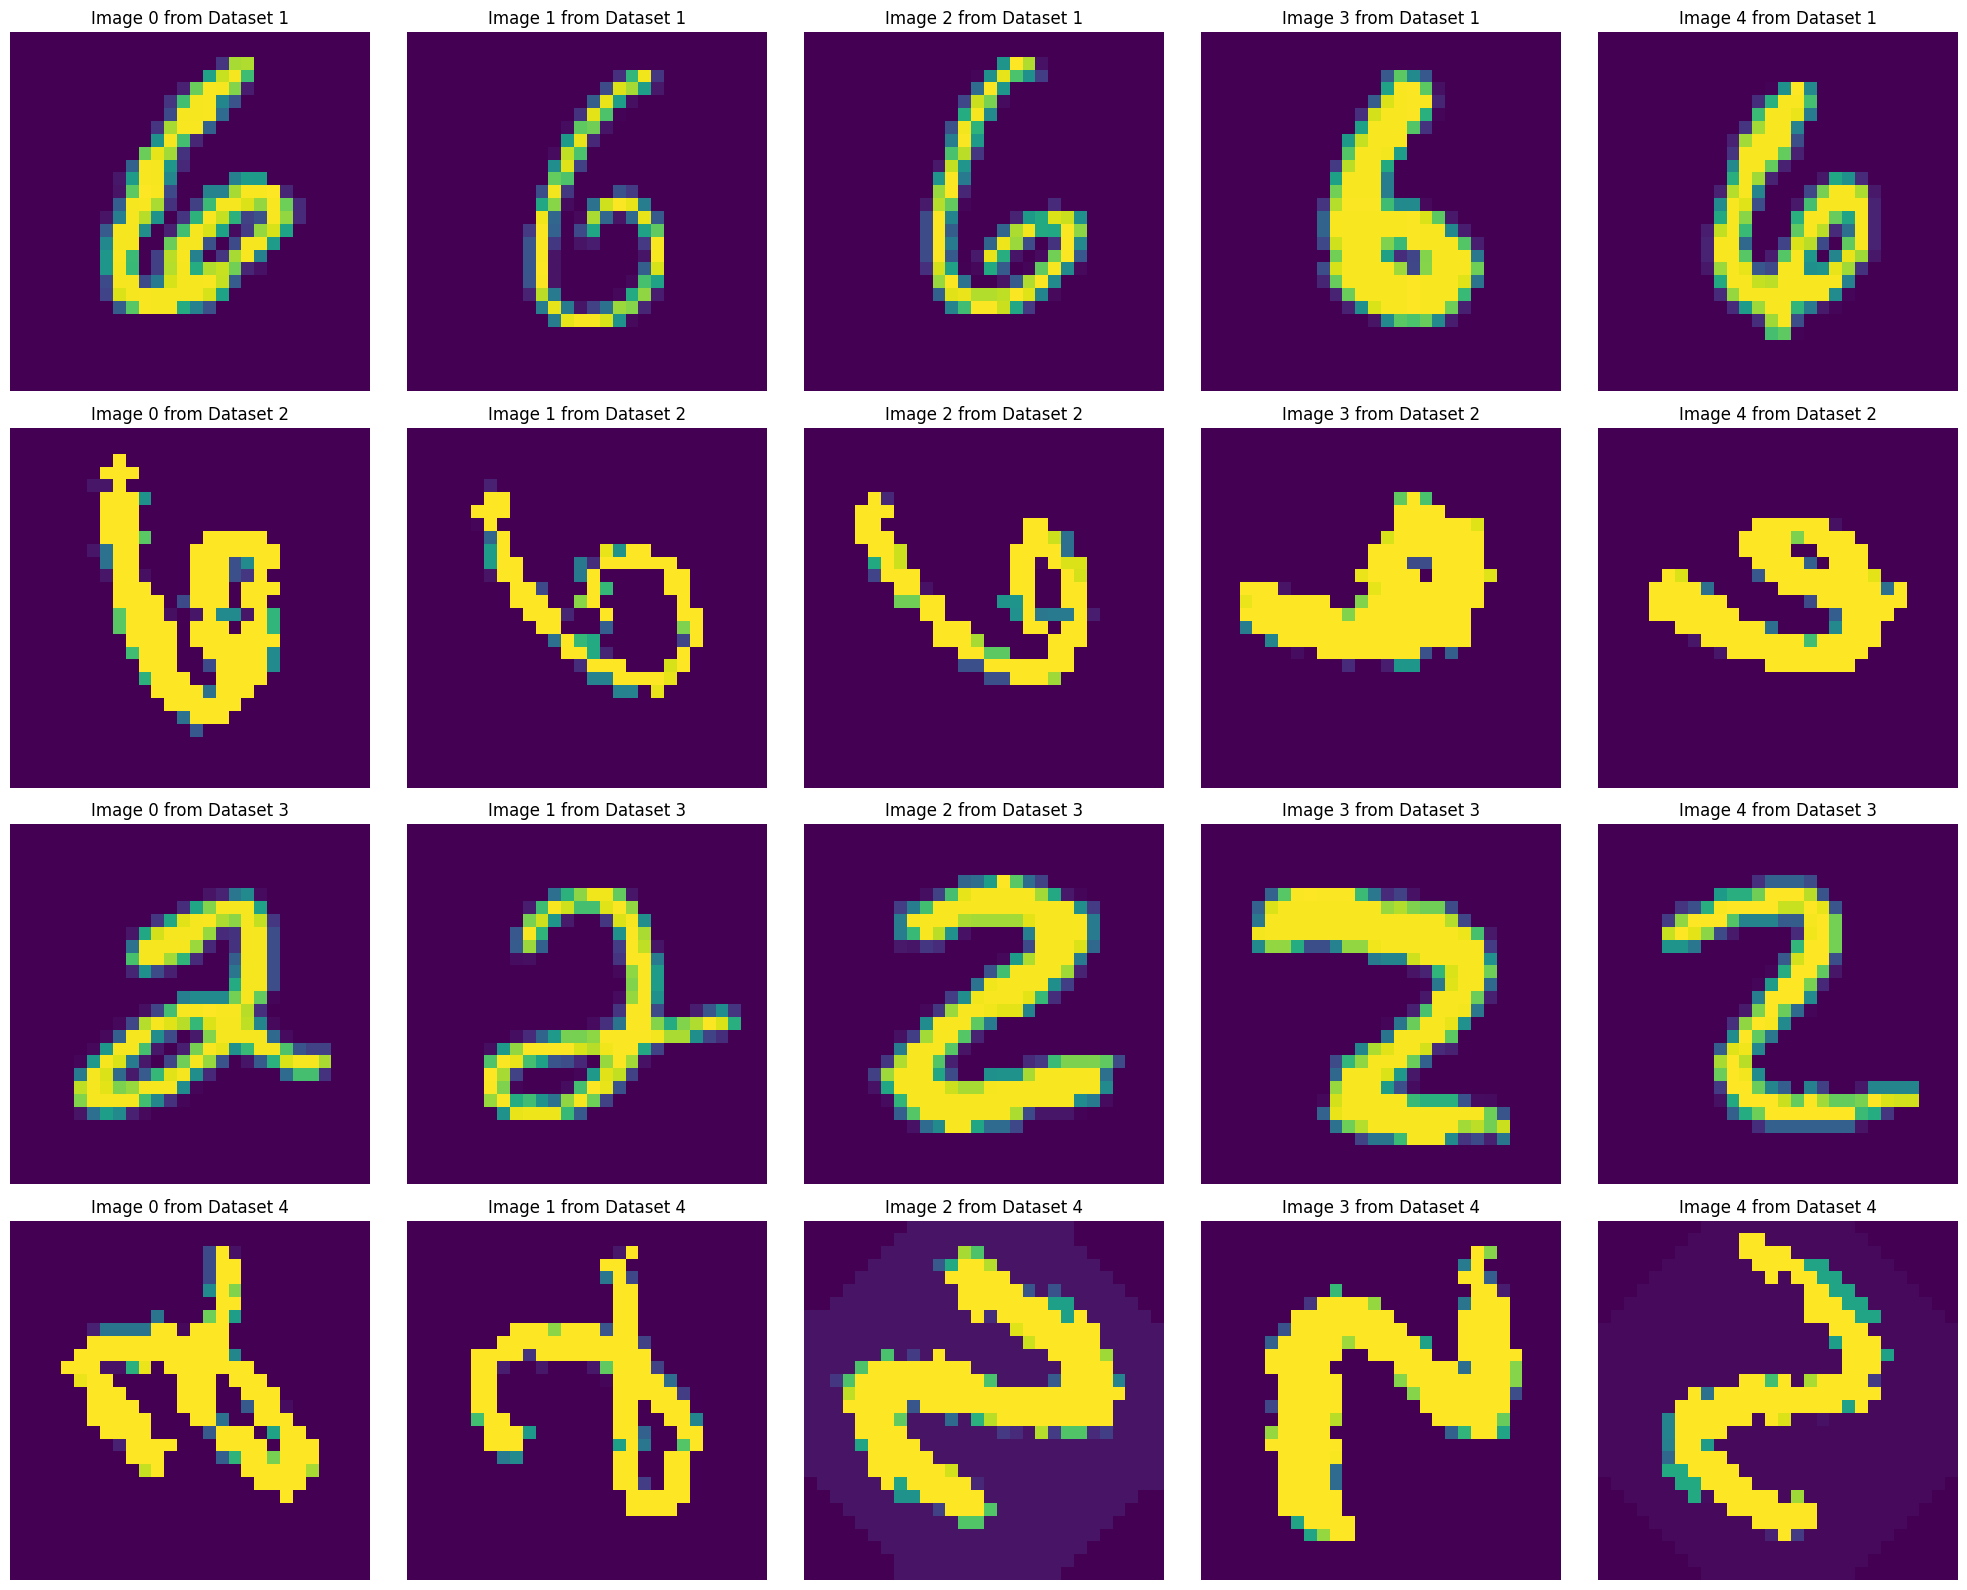

<Figure size 640x480 with 0 Axes>

In [3]:
plot_images_from_datasets(datasets=[ds_4, ds_4jr, ds_2, ds_2jr], num_images=5)

We now consider measures. Each dataset will be considered a measure:

$\mu = \sum a_i \delta_{xi}$

meaning that every image in the dataset is a dirac delta at point $x$, with probability mass of $a_i$. $x$ is the location of the dirac, and it has the coordinates of the flattened image. 

In [4]:
ds_2.__len__(), ds_4.__len__(), ds_2jr.__len__(), ds_4jr.__len__()

(5958, 5918, 5958, 5918)

Lets chose a training set of 1000 images from each dataset

In [5]:
n_samples = 1000
indices = np.arange(n_samples, dtype=int)

# Take the images
X_2 = np.array(ds_2.__getitem__(indices)[0])
X_4 = np.array(ds_4.__getitem__(indices)[0])
X_2jr = np.array(ds_2jr.__getitem__(indices)[0])
X_4jr = np.array(ds_4jr.__getitem__(indices)[0])

In [6]:
X_2.shape, X_4.shape, X_2jr.shape, X_4jr.shape

((1000, 784), (1000, 784), (1000, 784), (1000, 784))

Set the probability masses to uniform 1/n

In [7]:
a_i = 1.0 / n_samples
w_i = np.ones(shape=(n_samples,)) * a_i

Visualize the principal components of the datasets

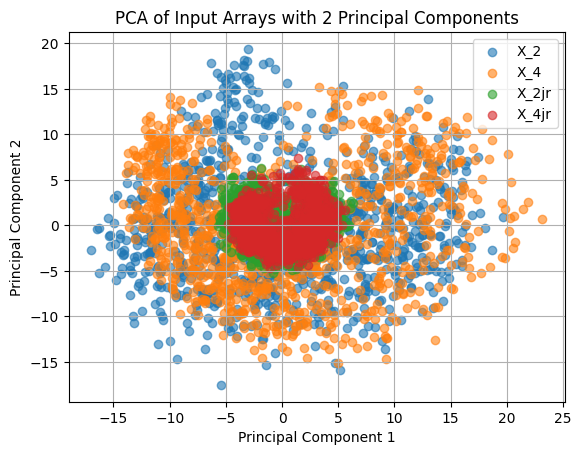

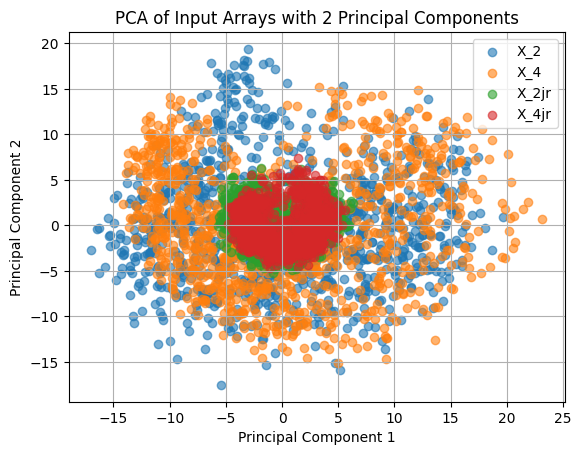

In [8]:
plot_pca_for_arrays(arrays=[X_2, X_4, X_2jr, X_4jr],
                    n_components=2,
                    labels=['X_2', 'X_4', 'X_2jr', 'X_4jr'])

Compute the Wasserstein barycenter of the four measures

In [29]:
recompute = False

if not recompute and os.path.exists('barycenter.npy'):
    barycenter = np.load('barycenter.npy')
else:
    barycenter = ot.bregman.free_support_sinkhorn_barycenter(
        measures_locations=[X_2, X_4, X_2jr, X_4jr],
        measures_weights=[w_i, w_i, w_i, w_i],
        X_init=np.random.randn(n_samples, X_2.shape[1]),
        reg=3.0,
        numItermax=2000,
        numInnerItermax=1000,
        verbose=True,
        stopThr=1e-7
    )

iteration %d, displacement_square_norm=%f
 0 778564.8868973154
iteration %d, displacement_square_norm=%f
 1 101465.9865616863
iteration %d, displacement_square_norm=%f
 2 18745.718008279757
iteration %d, displacement_square_norm=%f
 3 6431.285507018237
iteration %d, displacement_square_norm=%f
 4 1885.5650700434398
iteration %d, displacement_square_norm=%f
 5 439.7822854909924
iteration %d, displacement_square_norm=%f
 6 163.12682194605364
iteration %d, displacement_square_norm=%f
 7 74.81283095806353
iteration %d, displacement_square_norm=%f
 8 44.322153183075045
iteration %d, displacement_square_norm=%f
 9 25.463611768474856
iteration %d, displacement_square_norm=%f
 10 18.458288235258053
iteration %d, displacement_square_norm=%f
 11 14.45290052544047
iteration %d, displacement_square_norm=%f
 12 9.798993100428879
iteration %d, displacement_square_norm=%f
 13 7.160798998612535
iteration %d, displacement_square_norm=%f
 14 4.548334543402447
iteration %d, displacement_square_norm=%f
 1

In [32]:
# Save barycenter if kernel needs to be restarted
np.save('barycenter.npy', barycenter)

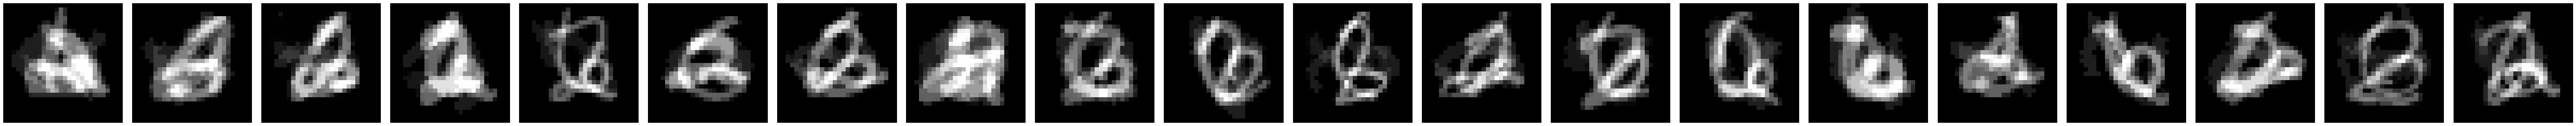

In [30]:
visualize_barycenter_diracs(barycenter=barycenter, num_images=20)

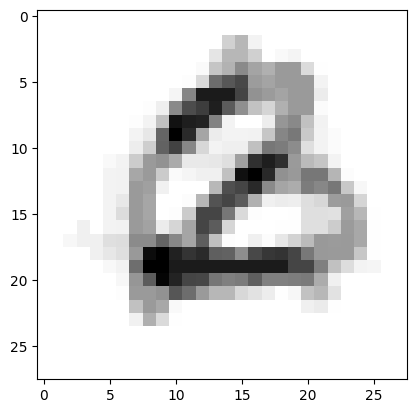

In [34]:
plt.imshow(barycenter[400].reshape(28, 28), cmap='Greys')